In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np
#import warnings

In [3]:
#warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('student_data.csv')
df.head()

,student_id,math,physics,english,history,geography,chemistry,biology,needs_help,availability
0,S1,63,98,88,75,65,70,62,"['chemistry', 'biology']","['Tuesday 10 AM - 12 PM', 'Monday 10 AM - 12 PM']"
1,S2,65,65,61,67,88,92,59,"['chemistry', 'math']","['Monday 2 PM - 4 PM', 'Tuesday 2 PM - 4 PM']"
2,S3,88,82,54,51,95,70,85,['english'],"['Monday 2 PM - 4 PM', 'Monday 10 AM - 12 PM']"
3,S4,57,65,75,75,50,52,61,['geography'],"['Tuesday 2 PM - 4 PM', 'Monday 2 PM - 4 PM']"
4,S5,79,61,100,81,82,86,50,['biology'],"['Tuesday 10 AM - 12 PM', 'Monday 10 AM - 12 PM']"


In [7]:
score_columns = ['math', 'physics', 'english', 'history', 'geography', 'chemistry', 'biology']
scores_df = df[score_columns]
scores_df.head()

,math,physics,english,history,geography,chemistry,biology
0,63,98,88,75,65,70,62
1,65,65,61,67,88,92,59
2,88,82,54,51,95,70,85
3,57,65,75,75,50,52,61
4,79,61,100,81,82,86,50


In [9]:
#Normalization and conversion back to dataframe for readibiltiy
scalar = MinMaxScaler()
scores_normalized = scalar.fit_transform(scores_df)

scores_normalized_df = pd.DataFrame(scores_normalized, columns = score_columns)
scores_normalized_df.head()

,math,physics,english,history,geography,chemistry,biology
0,0.26,0.96,0.76,0.489796,0.30,0.40,0.24
1,0.30,0.30,0.22,0.326531,0.76,0.84,0.18
2,0.76,0.64,0.08,0.000000,0.90,0.40,0.70
3,0.14,0.30,0.50,0.489796,0.00,0.04,0.22
4,0.58,0.22,1.00,0.612245,0.64,0.72,0.00


In [11]:
#K-Means with 3 clusters
kmeans = KMeans(n_clusters = 3, random_state = 0)
kmeans.fit(scores_normalized_df)

C:\Users\jroni\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, random_state=0)

In [13]:
df['cluster'] = kmeans.labels_
df.head()

,student_id,math,physics,english,history,geography,chemistry,biology,needs_help,availability,cluster
0,S1,63,98,88,75,65,70,62,"['chemistry', 'biology']","['Tuesday 10 AM - 12 PM', 'Monday 10 AM - 12 PM']",1
1,S2,65,65,61,67,88,92,59,"['chemistry', 'math']","['Monday 2 PM - 4 PM', 'Tuesday 2 PM - 4 PM']",1
2,S3,88,82,54,51,95,70,85,['english'],"['Monday 2 PM - 4 PM', 'Monday 10 AM - 12 PM']",2
3,S4,57,65,75,75,50,52,61,['geography'],"['Tuesday 2 PM - 4 PM', 'Monday 2 PM - 4 PM']",0
4,S5,79,61,100,81,82,86,50,['biology'],"['Tuesday 10 AM - 12 PM', 'Monday 10 AM - 12 PM']",0


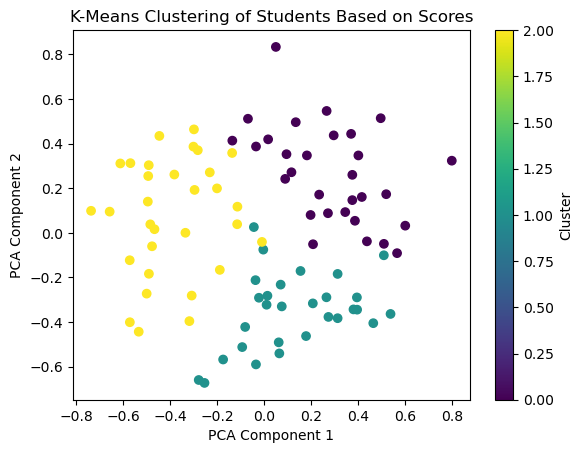

In [15]:
#PCA to visualise Clusters
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
scores_2d = pca.fit_transform(scores_normalized_df)

#plotting
plt.scatter(scores_2d[:, 0], scores_2d[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("K-Means Clustering of Students Based on Scores")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [17]:
def find_cluster_matches(student_id, threshold=70):  # Set threshold to 70
    # Returns the cluster of the given student
    student_cluster = df.loc[df['student_id'] == student_id, 'cluster'].values[0]
    
    # Returns the students in the same cluster
    cluster_students = df[df['cluster'] == student_cluster]
    
    # Fetches the subjects that require help
    needs_help_subjects = df.loc[df['student_id'] == student_id, 'needs_help'].values[0]
    
    # Ensure needs_help_subjects is in list format
    if isinstance(needs_help_subjects, str):
        import ast
        needs_help_subjects = ast.literal_eval(needs_help_subjects)

    matches = []
    for _, student in cluster_students.iterrows():
        if student_id != student['student_id']:  # Exclude the student themselves
            strengths = [subject for subject in score_columns if student[subject] >= threshold]
            print(f"Student {student['student_id']} strengths: {strengths}")  # Debugging statement
            print(f"Needs help subjects for {student_id}: {needs_help_subjects}")  # Debugging statement
            if any(subject in strengths for subject in needs_help_subjects):
                matches.append(student['student_id'])
    
    return matches


In [21]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(scores_normalized_df, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.13776957481065139


In [23]:
# Test with adjusted threshold
test_student_id = "S1"
cluster_matches = find_cluster_matches(test_student_id, threshold=70)
print(f"Potential matches for student {test_student_id} in their cluster: {cluster_matches}")


Student S2 strengths: ['geography', 'chemistry']
Needs help subjects for S1: ['chemistry', 'biology']
Student S6 strengths: ['math', 'english', 'history', 'geography']
Needs help subjects for S1: ['chemistry', 'biology']
Student S11 strengths: ['math', 'physics', 'chemistry']
Needs help subjects for S1: ['chemistry', 'biology']
Student S14 strengths: ['math', 'english', 'geography']
Needs help subjects for S1: ['chemistry', 'biology']
Student S24 strengths: ['math', 'physics', 'geography', 'chemistry']
Needs help subjects for S1: ['chemistry', 'biology']
Student S25 strengths: ['physics']
Needs help subjects for S1: ['chemistry', 'biology']
Student S26 strengths: []
Needs help subjects for S1: ['chemistry', 'biology']
Student S30 strengths: ['math', 'english', 'geography']
Needs help subjects for S1: ['chemistry', 'biology']
Student S34 strengths: ['math', 'physics', 'english', 'geography']
Needs help subjects for S1: ['chemistry', 'biology']
Student S41 strengths: ['math', 'english', 

In [25]:
# Check all students in the same cluster as S1
student_cluster = df.loc[df['student_id'] == 'S1', 'cluster'].values[0]
cluster_students = df[df['cluster'] == student_cluster]
print(cluster_students)

   student_id  math  physics  english  history  geography  chemistry  biology  \
0          S1    63       98       88       75         65         70       62   
1          S2    65       65       61       67         88         92       59   
5          S6    97       68       71       80         79         56       56   
10        S11    83       81       61       63         60         72       62   
13        S14    79       56       83       55         70         64       52   
23        S24    95       91       63       54         80         78       58   
24        S25    60       77       69       57         57         54       56   
25        S26    63       64       50       58         61         64       54   
29        S30    90       53       94       68         92         57       68   
33        S34    85       77       79       66         81         68       54   
40        S41    91       56       93       52         82         69       68   
44        S45    73       69

In [27]:
# Calculate mean scores for each cluster
cluster_means = df.groupby('cluster')[score_columns].mean()
print("Average Scores for Each Cluster:\n", cluster_means)

Average Scores for Each Cluster:
               math    physics    english    history  geography  chemistry  \
cluster                                                                     
0        67.100000  62.200000  84.833333  83.333333  65.466667  74.000000   
1        81.000000  78.586207  75.310345  67.068966  73.137931  65.379310   
2        75.451613  82.096774  70.225806  74.806452  80.032258  78.903226   

           biology  
cluster             
0        73.400000  
1        61.793103  
2        90.774194  
